In [1]:
#importing libraries and visualisation tools
# Data Manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#Statistic descriptives 
from scipy.stats import skew
from scipy.stats import kurtosis

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [36]:
#ExxonMobile
xone = pd.read_csv(r"C:\Users\Mr Mathonsi MM\Documents\Honours\Project\Data\XONE.csv")

In [37]:
xone = xone.copy()

In [38]:
xone.head()

Date       Open   High        Low      Close  Adj Close  Volume
0  2013-03-01  26.580000  27.49  26.070000  26.430000  26.430000  217200
1  2013-03-04  27.750000  28.82  27.000000  27.230000  27.230000  825600
2  2013-03-05  28.000000  28.15  26.299999  26.520000  26.520000  431100
3  2013-03-06  27.219999  27.50  26.620001  26.790001  26.790001  262600
4  2013-03-07  26.950001  27.74  26.500000  27.590000  27.590000  297400

In [39]:
# Predictor variables
xone['Open-Close']= xone.Open -xone.Close
xone['High-Low']  = xone.High - xone.Low
xone =xone.dropna()
X= xone[['Open-Close', 'High-Low']]
X.head()

Open-Close  High-Low
0    0.150000  1.420000
1    0.520000  1.820000
2    1.480000  1.850001
3    0.429998  0.879999
4   -0.639999  1.240000

In [40]:
# Target variable
Y= np.where(xone['Adj Close'].shift(-1)>xone['Adj Close'],1,-1)

In [41]:
Y = (Y - min(Y))/(max(Y)- min(Y))

In [42]:
# Splitting the dataset
split_percentage = 0.2
split = int(split_percentage*len(xone))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [43]:
# Instantiate KNN learning model(k=150)
knn = KNeighborsClassifier(n_neighbors=100)

# fit the model
knn.fit(X_train, Y_train)

# Accuracy Score
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.56
Test_data Accuracy: 0.49


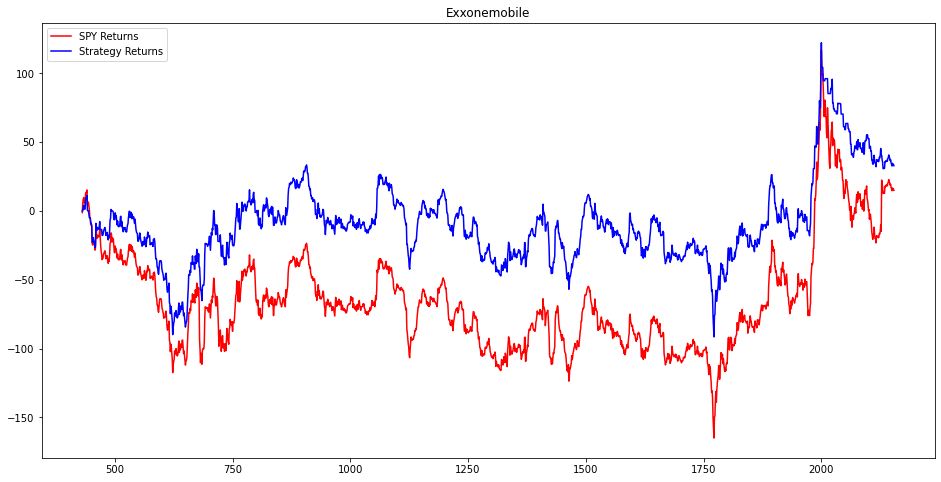

In [44]:
# Predicted Signal
xone['Predicted_Signal'] = knn.predict(X)

# SPY Cumulative Returns
xone['SPY_returns'] = np.log(xone['Adj Close']/xone['Adj Close'].shift(1))
Cumulative_SPY_returns = xone[split:]['SPY_returns'].cumsum()*100

# Cumulative Strategy Returns 
xone['Startegy_returns'] = xone['SPY_returns']* xone['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = xone[split:]['Startegy_returns'].cumsum()*100

# Plot the results to visualize the performance

plt.figure(figsize=(16,8))
plt.plot(Cumulative_SPY_returns, color='r',label = 'SPY Returns')
plt.plot(Cumulative_Strategy_returns, color='b', label = 'Strategy Returns')
plt.legend()
plt.title('Exxonemobile')
plt.savefig('knnexxone.jpg')
plt.show()


In [45]:
# Calculate Sharpe ratio
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns-Cumulative_SPY_returns)/Std
Sharpe = Sharpe.mean()
print('Sharpe ratio: %.2f'%Sharpe )

Sharpe ratio: 1.84


In [46]:
# Features construction 
xone['Open-Close'] = (xone.Open - xone.Close)/xone.Open
xone['High-Low'] = (xone.High - xone.Low)/xone.Low
xone['percent_change'] = xone['Adj Close'].pct_change()
xone['std_5'] = xone['percent_change'].rolling(5).std()
xone['ret_5'] =xone['percent_change'].rolling(5).mean()
xone.dropna(inplace=True)

# X is the input variable
X = xone[['Open-Close', 'High-Low', 'std_5', 'ret_5']]

# Y is the target or output variable
y = np.where(xone['Adj Close'].shift(-1) > xone['Adj Close'], 1, -1)

In [47]:
# Total dataset length
dataset_length = xone.shape[0]

# Training dataset length
split = int(dataset_length * 0.2)
split

430

In [48]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(430, 4) (1720, 4)
(430,) (1720,)


In [49]:
clf = RandomForestClassifier(random_state=5)
# Create the model on train dataset
model = clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
print('Correct Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)

Correct Prediction (%):  49.53488372093023


In [50]:
# Run the code to view the classification report metrics
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)


              precision    recall  f1-score   support

          -1       0.51      0.57      0.54       893
           1       0.47      0.41      0.44       827

    accuracy                           0.50      1720
   macro avg       0.49      0.49      0.49      1720
weighted avg       0.49      0.50      0.49      1720



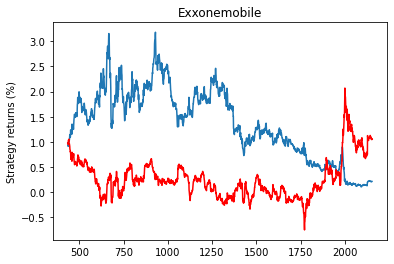

In [51]:
# SPY Cumulative Returns
xone['SPY_returns'] = np.log(xone['Adj Close']/xone['Adj Close'].shift(1))
Cumulative_SPY_returns = xone[split:]['SPY_returns'].cumsum()+1


xone['strategy_returns'] = xone.percent_change.shift(-1) * model.predict(X)
#(xone.strategy_returns[split:]+1).cumprod().plot()
plt.plot(Cumulative_SPY_returns, color='r',label = 'SPY Returns')
plt.ylabel('Strategy returns (%)')
plt.title('Exxonemobile')
plt.savefig('rfexxone.jpg')
plt.show()
